<a href="https://colab.research.google.com/github/sanu00007/Deep_Learning/blob/main/CNN_PRACTICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Convert MNIST Image Files into tensor of 4-Dimensions (# of images ,Height,Width,color channel)
transforms = transforms.ToTensor()
train_data = datasets.MNIST(root='/data',train=True,download=True,transform=transforms)
test_data = datasets.MNIST(root='/data',train=False,download=True,transform=transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 157058981.56it/s]


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 47616231.85it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 43892028.72it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7605001.50it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#create a small batch size for images.....lets say 10
train_loader = DataLoader(train_data,batch_size=10,shuffle = True)
test_loader = DataLoader(test_data,batch_size=10,shuffle = False)

In [12]:
#define our cnn model
#describe convolution layer ans there are 2 layer

#just an example

conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1) #6 output from conv1 are input of conv2

In [13]:
#Grab 1 MNIST record/image
for i,(X_train,y_train) in enumerate(train_data):
    break

In [24]:
X_train.shape

torch.Size([1, 28, 28])

In [30]:
x = X_train.view(1,1,28,28) #4Dimension

In [31]:
#Perform out first convolution
x = F.relu(conv1(x)) #Rectify Linear unit for our activation fuction
# 1 single image, 6 is filter we asked for, 26x26
x.shape


torch.Size([1, 6, 26, 26])

In [32]:
#pooling layer
x = F.max_pool2d(x,2,2) #max_pool
x.shape

#since pooling is 2x2 it change to 13x13 from 26x26

torch.Size([1, 6, 13, 13])

In [33]:
#Do our second convolution ayer
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [34]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [35]:
((28-2)/2-2)/2

5.5

In [64]:
#Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)
        #Fully Conected layer
        self.fc1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=84)
        self.fc3 = nn.Linear(in_features=84,out_features=10)

    def forward(self,X):
      #first pass
      X = F.relu(self.conv1(X))
      X = F.max_pool2d(X,2,2)
      #second pass
      X = F.relu(self.conv2(X))
      X = F.max_pool2d(X,2,2)

      X = X.view(-1,16*5*5)
      #Fully connected layer
      X = F.relu(self.fc1(X))
      X = F.relu(self.fc2(X))
      X = self.fc3(X)
      return F.log_softmax(X,dim=1)

In [65]:
#Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [66]:
#Loss Function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) #smaller the learning rate, longer its gonna take to train



In [78]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 1.2909532415505964e-05
Epoch: 0  Batch: 1200  Loss: 0.00042155274422839284
Epoch: 0  Batch: 1800  Loss: 0.0024611474946141243
Epoch: 0  Batch: 2400  Loss: 1.0728830091011332e-07
Epoch: 0  Batch: 3000  Loss: 1.716605538604199e-06
Epoch: 0  Batch: 3600  Loss: 0.00019490966224111617
Epoch: 0  Batch: 4200  Loss: 5.626531674352009e-06
Epoch: 0  Batch: 4800  Loss: 4.851759058510652e-06
Epoch: 0  Batch: 5400  Loss: 2.9802276912960224e-07
Epoch: 0  Batch: 6000  Loss: 3.0024326406419277e-05
Epoch: 1  Batch: 600  Loss: 0.06062393635511398
Epoch: 1  Batch: 1200  Loss: 0.0007284864550456405
Epoch: 1  Batch: 1800  Loss: 1.311301929263209e-07
Epoch: 1  Batch: 2400  Loss: 2.548458542150911e-05
Epoch: 1  Batch: 3000  Loss: 1.423262438038364e-05
Epoch: 1  Batch: 3600  Loss: 1.4901077065587742e-06
Epoch: 1  Batch: 4200  Loss: 3.5887565900338814e-05
Epoch: 1  Batch: 4800  Loss: 0.00038170506013557315
Epoch: 1  Batch: 5400  Loss: 2.6341876946389675e-05
Epoch: 1  Batch: 6000  Lo

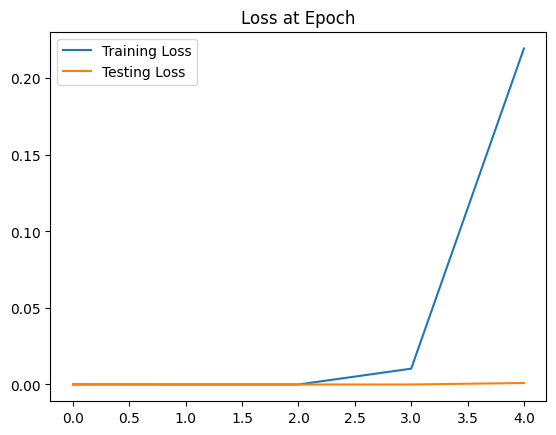

In [79]:
#Graph the loss at epoch
train_losses = [t.item() for t in train_losses]
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

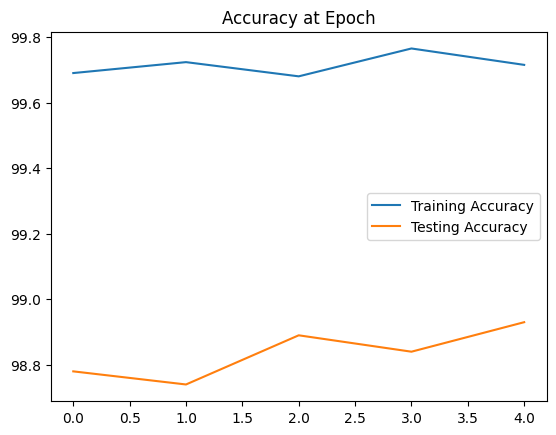

In [81]:
#graph the accuracy at the end of the epoch
train_accuracy = [t/600 for t in train_correct]
plt.plot(train_accuracy,label='Training Accuracy')
test_correct = [t/100 for t in test_correct]
plt.plot(test_correct,label='Testing Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

In [82]:
test_load_everything = DataLoader(test_data,batch_size=10000,shuffle=False)

In [84]:
with torch.no_grad():
  correct = 0
  for b,(X_test,y_test) in enumerate(test_load_everything):
    y_val = model(X_test)
    predicted = torch.max(y_val.data,1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct/10000}')

Test Accuracy: 0.989300012588501


In [88]:
#Did for correct
correct.item()/len(test_data
                   )*100  #percentage

98.92999999999999

**Image detection**

In [90]:
  test_data[4146] #Tensor with an image in it

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [91]:
#Grab just the data
test_data[4146][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [93]:
#Reshape
test_data[4146][0].reshape(28,28)


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

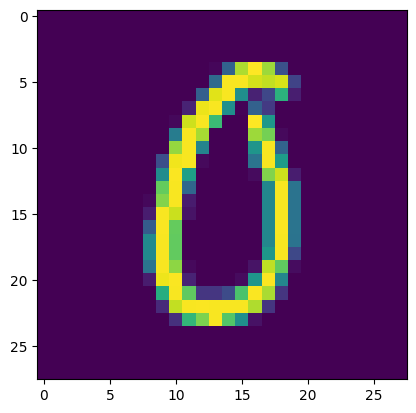

In [94]:
#Show the image
plt.imshow(test_data[4146][0].reshape(28,28))

In [95]:
#pass the image to model
model.eval()
with torch.no_grad():
  test_image = model(test_data[4146][0].view(1,1,28,28)) #batch size of 1, 1 color channel

In [96]:
test_image

tensor([[  0.0000, -53.1838, -66.0041, -76.5698, -73.3046, -42.8735, -17.3603,
         -68.5618, -34.2742, -53.0827]])

In [97]:
test_image.argmax()

tensor(0)